In [ ]:
import pandas as pd
!pip install seaborn

import seaborn as sns
import numpy as np
from sklearn import set_config
set_config(display = 'diagram')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df1 = pd.read_csv('/content/dataset (2).csv')

In [ ]:
df1.columns

Index(['ID', 'SystemCodeNumber', 'Capacity', 'Latitude', 'Longitude',
       'Occupancy', 'VehicleType', 'TrafficConditionNearby', 'QueueLength',
       'IsSpecialDay', 'LastUpdatedDate', 'LastUpdatedTime'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
import pickle


from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load dataset
df = df
import pandas as pd

# Drop unnecessary columns
df2 = df.drop(['ID', 'Latitude', 'Longitude'], axis=1)

# Convert LastUpdatedDate with dayfirst format and extract month and day
df2['LastUpdatedDate'] = pd.to_datetime(df2['LastUpdatedDate'], dayfirst=True)
df2['Month'] = df2['LastUpdatedDate'].dt.month
df2['Date'] = df2['LastUpdatedDate'].dt.day

# Convert LastUpdatedTime (with seconds) and extract hour and minute
df2['LastUpdatedTime'] = pd.to_datetime(df2['LastUpdatedTime'], format='%H:%M:%S')
df2['Hour'] = df2['LastUpdatedTime'].dt.hour
df2['Minute'] = df2['LastUpdatedTime'].dt.minute

# Drop original datetime columns
df2 = df2.drop(['LastUpdatedDate', 'LastUpdatedTime'], axis=1)

# Output
print(df2.head())
print(df2.columns)
print(df2.info())
df=df2

# Normalize TrafficConditionNearby values to match expected ordinal categories
df['TrafficConditionNearby'] = df['TrafficConditionNearby'].str.capitalize()

# Label encode VehicleType (must be done outside the ColumnTransformer)
df['VehicleType'] = LabelEncoder().fit_transform(df['VehicleType'])

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['SystemCodeNumber']),
        ('ordinal', OrdinalEncoder(categories=[['Low', 'Average', 'High']]), ['TrafficConditionNearby'])
    ],
    remainder='passthrough'  # Keep the rest of the columns
)

# Apply the transformations
transformed_data = preprocessor.fit_transform(df)

# Retrieve column names
onehot_feature_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(['SystemCodeNumber'])

# Define final column names
final_columns = list(onehot_feature_names) + ['TrafficConditionNearby'] + [
    col for col in df.columns if col not in ['SystemCodeNumber', 'TrafficConditionNearby']
]

# Create final DataFrame
df = df_transformed = pd.DataFrame(transformed_data, columns=final_columns)

# Convert data to numeric (optional, to avoid dtype 'object')
df_transformed = df_transformed.apply(pd.to_numeric, errors='ignore')

# Output
print(df_transformed.head())
print(df_transformed.columns)
print(df_transformed.info())


# Load dataset
df = df_transformed

X = df.drop(columns=['PredictedPrice'], errors='ignore')
y = df['PredictedPrice']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Columns for PowerTransformer
power_transform_cols = ['Occupancy', 'QueueLength']
numeric_cols = X.columns

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('power', PowerTransformer(), power_transform_cols),
    ('scale', StandardScaler(), numeric_cols.difference(power_transform_cols))
])

# Evaluation function
def evaluate_regression_model(X_train, y_train, X_test, y_test, pipeline_model, param_grid, model_name):
    search = RandomizedSearchCV(
        pipeline_model,
        param_distributions=param_grid,
        n_iter=10,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring='r2',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    print(f"\nRunning RandomizedSearchCV for {model_name}")
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    best_params = search.best_params_
    best_cv_score = search.best_score_

    y_pred = best_model.predict(X_test)

    test_r2 = r2_score(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    n = len(y_test)
    p = X.shape[1]
    test_adjusted_r2 = 1 - (1 - test_r2) * (n - 1) / (n - p - 1)

    print(f"\nBest Params: {best_params}")
    print(f"CV R² Score: {best_cv_score:.4f}")
    print(f"Test R² Score: {test_r2:.4f}")
    print(f"Test Adjusted R²: {test_adjusted_r2:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    return best_model, test_r2

# Store models and accuracies
models_info = {}

# --- Linear Regression ---
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_param_grid = {}  # No hyperparameters for LinearRegression

best_lr_model, lr_r2 = evaluate_regression_model(
    X_train, y_train, X_test, y_test, lr_pipeline, lr_param_grid, 'LinearRegression'
)
models_info['LinearRegression'] = (best_lr_model, lr_r2)

# --- Random Forest Regressor ---
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
rf_param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['auto', 'sqrt']
}

best_rf_model, rf_r2 = evaluate_regression_model(
    X_train, y_train, X_test, y_test, rf_pipeline, rf_param_grid, 'RandomForestRegressor'
)
models_info['RandomForestRegressor'] = (best_rf_model, rf_r2)

# --- XGBoost Regressor ---
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, verbosity=0))
])
xgb_param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__subsample': [0.7, 1.0],
    'regressor__colsample_bytree': [0.7, 1.0]
}

best_xgb_model, xgb_r2 = evaluate_regression_model(
    X_train, y_train, X_test, y_test, xgb_pipeline, xgb_param_grid, 'XGBRegressor'
)
models_info['XGBRegressor'] = (best_xgb_model, xgb_r2)

# --- Summary and Save Best Model ---
print("\n--- Final Model Comparison ---")
for model_name, (_, r2) in models_info.items():
    print(f"{model_name}: R² = {r2:.4f}")

best_model_name = max(models_info, key=lambda k: models_info[k][1])
best_model = models_info[best_model_name][0]
print(f"\nBest Model: {best_model_name}")

# Save best model
with open(f'best_model2_{best_model_name}.pkl', 'wb') as file:
    pickle.dump(best_model, file)
print(f"Best model saved as 'best_model_{best_model_name}.pkl'")


  SystemCodeNumber  Capacity  Occupancy VehicleType TrafficConditionNearby  \
0      BHMBCCMKT01       577         61         car                    low   
1      BHMBCCMKT01       577         64         car                    low   
2      BHMBCCMKT01       577         80         car                    low   
3      BHMBCCMKT01       577        107         car                    low   
4      BHMBCCMKT01       577        150        bike                    low   

   QueueLength  IsSpecialDay  TrafficLevel  VehicleTypeWeight  Hour  ...  \
0            1             0             1                1.0     7  ...   
1            1             0             1                1.0     8  ...   
2            2             0             1                1.0     8  ...   
3            2             0             1                1.0     9  ...   
4            2             0             1                0.5     9  ...   

       Beta     Gamma     Delta    Epsilon  Price_alpha  Price_beta  \
0  

In [ ]:
! pip install ydata-profiling
from ydata_profiling import ProfileReport
prof = ProfileReport(df)
prof.to_file(output_file='output.html')

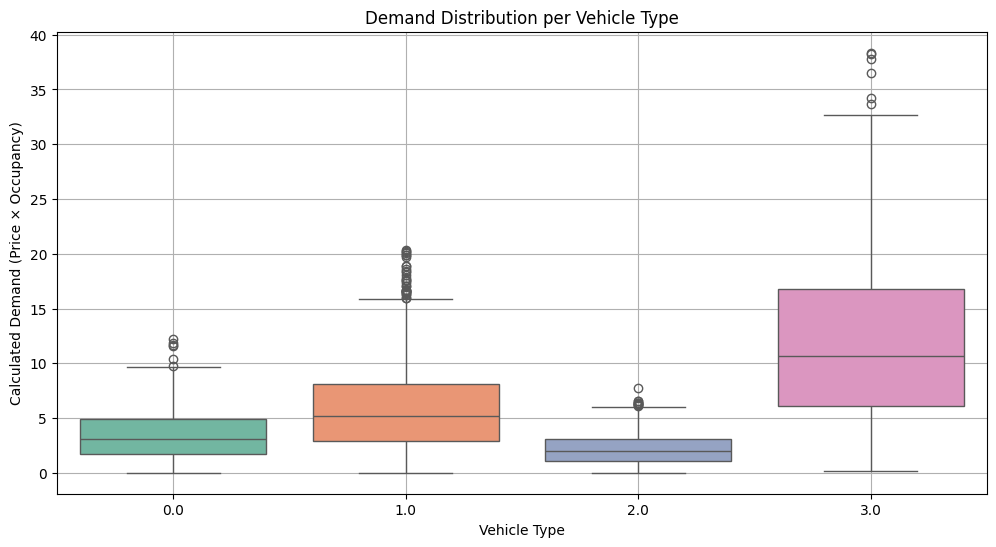

In [ ]:
import seaborn as sns

# Assuming: Demand = Price * Occupancy Ratio
df['Demand'] = df['Price'] * df['OccRatio']

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='VehicleType', y='Demand', palette='Set2')
plt.title("Demand Distribution per Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Calculated Demand (Price × Occupancy)")
plt.grid(True)
plt.show()


In [ ]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c  # in kilometers


In [ ]:
def adjust_price(current_row, df, radius_km=0.5):
    base_price = current_row['Price']
    lat, lon = current_row['Latitude'], current_row['Longitude']

    # Find competitors within the radius
    df['Distance'] = df.apply(lambda row: haversine(lat, lon, row['Latitude'], row['Longitude']), axis=1)
    nearby = df[(df['Distance'] < radius_km) & (df.index != current_row.name)]

    if nearby.empty:
        return base_price  # No competitors nearby, keep same price

    avg_competitor_price = nearby['Price'].mean()

    if current_row['OccRatio'] > 0.95 and avg_competitor_price < base_price:
        return base_price * 0.90  # reduce price to stay competitive
    elif avg_competitor_price > base_price:
        return base_price * 1.10  # slight increase
    else:
        return base_price


In [ ]:
df.rename(columns={
    'lat': 'Latitude',
    'lon': 'Longitude'
}, inplace=True)


In [ ]:
required_columns = ['Latitude', 'Longitude', 'Price', 'OccRatio']

# Check if all required columns are present
missing = [col for col in required_columns if col not in df.columns]

if missing:
    print("Missing columns:", missing)
else:
    df['AdjustedPrice'] = df.apply(lambda row: adjust_price(row, df), axis=1)


Missing columns: ['Latitude', 'Longitude']


In [ ]:
df

,SystemCodeNumber_BHMBCCMKT01,SystemCodeNumber_BHMBCCTHL01,SystemCodeNumber_BHMEURBRD01,SystemCodeNumber_BHMMBMMBX01,SystemCodeNumber_BHMNCPHST01,SystemCodeNumber_BHMNCPNST01,SystemCodeNumber_Broad Street,SystemCodeNumber_Others-CCCPS105a,SystemCodeNumber_Others-CCCPS119a,SystemCodeNumber_Others-CCCPS135a,...,Gamma,Delta,Epsilon,Price_alpha,Price_beta,Price_gamma,Price_delta,Price_epsilon,PredictedPrice,Demand
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.736677,1.463757,12.929666,1.86,4.82,3.68,0.0,64.65,80.00,0.702952
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.736677,1.463757,12.929666,1.95,4.82,3.68,0.0,64.65,80.10,0.694157
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.736677,1.463757,12.929666,2.43,9.63,3.68,0.0,64.65,85.40,1.043867
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.736677,1.463757,12.929666,3.26,9.63,3.68,0.0,64.65,86.22,1.496760
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.736677,1.463757,12.929666,2.74,5.78,2.21,0.0,19.39,33.12,1.301437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.736677,1.463757,12.929666,27.74,57.80,14.73,0.0,193.94,304.22,20.782954
18364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.736677,1.463757,12.929666,13.60,14.45,3.68,0.0,64.65,101.38,8.057892
18365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.736677,1.463757,12.929666,5.24,5.78,1.47,0.0,7.76,22.25,3.002555
18366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.736677,1.463757,12.929666,12.08,9.63,3.68,0.0,64.65,95.04,6.265388
